In [9]:
import numpy as np
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/zhangkewen/Documents/scripts/voltagecalculate_1125')
import AiresInfoFunctions as Aires
from scipy.fftpack import fft, ifft 

In [2]:
Inclination = 62.27
Declination = 0
Inclination = Inclination * np.pi / 180 + np.pi / 2
Bx = np.cos(Declination) * np.sin(Inclination)
By = np.sin(Declination) * np.sin(Inclination)
Bz = np.cos(Inclination)
B_field=np.array([Bx,By,Bz])

In [7]:
def get_in_shower_plane(pos_, k_, core_decay_, inclination_, declination_):

    _pos = (pos_ - core_decay_).T
    _B = np.array([np.cos(declination_)*np.sin(inclination_), np.sin(declination_)*np.sin(inclination_),np.cos(inclination_)])
    _kxB = np.cross(k_,_B)
    _kxB /= np.linalg.norm(_kxB)
    _kxkxB = np.cross(k_,_kxB)
    _kxkxB /= np.linalg.norm(_kxkxB)
    return np.array([np.dot(_kxB, _pos), np.dot(_kxkxB, _pos), np.dot(k_, _pos)])


def get_fluence(trace):
    #integrate in frequency domain
    return sum(abs(trace) ** 2) / 2000

def get_f_vB_vvB(E_,k_,_B):
    #in frequency domain
    _kxB = np.cross(k_,_B)
    _kxB /= np.linalg.norm(_kxB)
    _kxkxB = np.cross(k_,_kxB)
    _kxkxB /= np.linalg.norm(_kxkxB)
    E_vB=np.dot(_kxB,E_)
    E_vvB=np.dot(_kxkxB,E_)
    fluence_vB=get_fluence(E_vB)
    fluence_vvB=get_fluence(E_vvB)
    return fluence_vB,fluence_vvB

def compute_f_geo_ce(fluence_evB, fluence_evvB , r_plane):
    cosPhi = np.dot(r_plane, np.array([1, 0])) / np.linalg.norm(r_plane)
    Phi=np.arcsin(r_plane[1]/np.sqrt(r_plane[0]**2+r_plane[1]**2))
    cosPhi =np.cos(Phi)# r_plane[0]/np.sqrt(r_plane[0]**2+r_plane[1]**2)
    sinPhi = np.sin(Phi)#np.sqrt(1 - cosPhi * cosPhi)

    if (
        abs(sinPhi)>0.2
    ):  # Exclude stations too close to the v\times B direction
        fluence_geo = np.sqrt(fluence_evB) - (
            cosPhi / sinPhi
        ) * np.sqrt(fluence_evvB)
        fluence_geo = fluence_geo * fluence_geo
        fluence_ce = fluence_evvB / (sinPhi * sinPhi)
    else:
        fluence_geo = 0
        fluence_ce = 0
    return fluence_geo, fluence_ce


In [17]:
dir_='/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/test/Stshp_MZS_QGS204JET_Proton_3.98_79.6_90.0_9'
r_Core_proj=np.array([0,0,2100])
core=np.array([0,0,2100])
freq_lower=50
freq_upper=200

ids, x, y, z = np.loadtxt(dir_ + '/antpos.dat', usecols=[0, 2, 3, 4]).T
sryfile = dir_ +'/'+ dir_.split('/')[-1]+'.sry'
zenith = Aires.GetZenithAngleFromSry(sryfile) * np.pi / 180  
azimuth = Aires.GetAzimuthAngleFromSry(sryfile) * np.pi / 180  
k_shower = np.array([np.sin(zenith) * np.cos(azimuth), np.sin(zenith) * np.sin(azimuth), np.cos(zenith)])
_, xmax, x_xmax, y_xmax, z_xmax = Aires.GetKmXmaxFromSry(sryfile)
x_xmax, y_xmax, z_xmax = x_xmax * 1e3, y_xmax * 1e3, z_xmax * 1e3
xsp, ysp, zsp = get_in_shower_plane(np.array([x, y, z]).T, k_shower, np.array([x_xmax, y_xmax, z_xmax]), Inclination,Declination)
r_proj =np.array([xsp, ysp, zsp])
la=np.sqrt((x-x_xmax)**2+(y-y_xmax)**2+(z-z_xmax)**2)
DXmax=abs((z_xmax-2100)/np.cos(zenith))#2100 Ground Altitude

farr_evB = np.array([])
farr_ev = np.array([])
farr_evvB = np.array([])
farr_ce = np.array([])
farr_geo = np.array([])
Sinphi = np.array([])

for ant in range(160):
    tracef = dir_ + '/' + dir_.split('/')[-1] + '/a' + str(ant) + '.trace'
    t,ex,ey,ez=np.loadtxt(tracef).T
    ex=np.append(0,ex)
    ey=np.append(0,ey)
    ez=np.append(0,ez)
    Edata_fft=np.array([fft(ex),fft(ey),fft(ez)]).T
    E_filter = np.zeros((2000, 3), dtype='complex')
    for i in range(2000):
        for j in range(3):
            if i >= freq_lower and i <= freq_upper:
                E_filter[i, j] = Edata_fft[i, j]
            if i >= 2000 - freq_upper and i <= 2000 - freq_lower:
                E_filter[i, j] = Edata_fft[i, j]
    e_mag_fft = np.sqrt(abs(E_filter[:, 0] ) ** 2 + abs(E_filter[:, 1] ) ** 2 + abs(E_filter[:, 2] ) ** 2)
    e_fluence =get_fluence(e_mag_fft)
    u_ant = np.array([x[ant]-x_xmax, y[ant]-y_xmax, z[ant]-z_xmax]) / la[ant]
    omega =  np.arccos(np.dot(k_shower, u_ant))#
    la_proj=la[ant]*np.cos(omega)
    fluence_evB, fluence_evvB= get_f_vB_vvB(E_filter.T, k_shower, B_field)
    fluence_ev=get_fluence(np.dot(k_shower,E_filter.T))
    r_plane = r_proj[0:2, ant]
    weight=abs(la_proj/DXmax)**2
    fluence_geo_w, fluence_ce_w = compute_f_geo_ce(fluence_evB*weight , fluence_evvB*weight , r_plane)
    farr_ev = np.append(farr_ev, fluence_ev*weight)
    farr_evB = np.append(farr_evB, fluence_evB*weight)
    farr_evvB = np.append(farr_evvB, fluence_evvB*weight)
    farr_ce = np.append(farr_ce, fluence_ce_w)
    farr_geo = np.append(farr_geo, fluence_geo_w)
    Sinphi = np.append(Sinphi, r_plane[1]/np.sqrt(r_plane[0]**2+r_plane[1]**2))



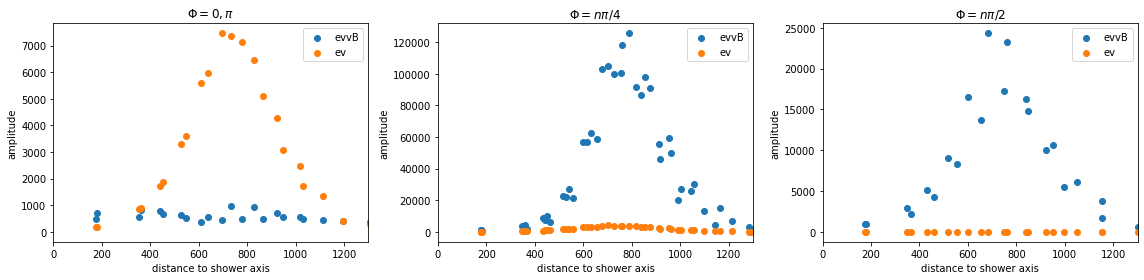

In [18]:
d2r=np.sqrt(xsp[0:160]**2+ysp[0:160]**2)
d2r_sel=d2r[(abs(Sinphi)<0.3)]
farr_ev_sel=farr_ev[(abs(Sinphi)<0.3)]
farr_evvB_sel=farr_evvB[(abs(Sinphi)<0.3)]
farr_evB_sel=farr_evB[(abs(Sinphi)<0.3)]
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.scatter(d2r_sel,farr_evvB_sel,label='evvB')
plt.scatter(d2r_sel,farr_ev_sel,label='ev')
#plt.scatter(d2r_sel,farr_evB_sel,label='evB')
plt.legend()
plt.xlim([0,1300])
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.title(r'$\Phi=0,\pi$')
plt.subplot(1,3,2)
d2r_sel=d2r[(abs(Sinphi)>0.3)&(abs(Sinphi)<0.8)]
farr_ev_sel=farr_ev[(abs(Sinphi)>0.3)&(abs(Sinphi)<0.8)]
farr_evvB_sel=farr_evvB[(abs(Sinphi)>0.3)&(abs(Sinphi)<0.8)]
farr_evB_sel=farr_evB[(abs(Sinphi)>0.3)&(abs(Sinphi)<0.8)]
plt.scatter(d2r_sel,farr_evvB_sel,label='evvB')
plt.scatter(d2r_sel,farr_ev_sel,label='ev')
#plt.scatter(d2r_sel,farr_evB_sel,label='evB')
plt.legend()
plt.xlim([0,1300])
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.title(r'$\Phi=n\pi/4$')

plt.subplot(1,3,3)
d2r_sel=d2r[(abs(Sinphi)>0.8)]
farr_ev_sel=farr_ev[(abs(Sinphi)>0.8)]
farr_evvB_sel=farr_evvB[(abs(Sinphi)>0.8)]
farr_evB_sel=farr_evB[(abs(Sinphi)>0.8)]
plt.scatter(d2r_sel,farr_evvB_sel,label='evvB')
plt.scatter(d2r_sel,farr_ev_sel,label='ev')
#plt.scatter(d2r_sel,farr_evB_sel,label='evB')
plt.legend()
plt.xlim([0,1300])
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.title(r'$\Phi=n\pi/2$')
plt.tight_layout()

Text(0.5, 1.0, 'ce')

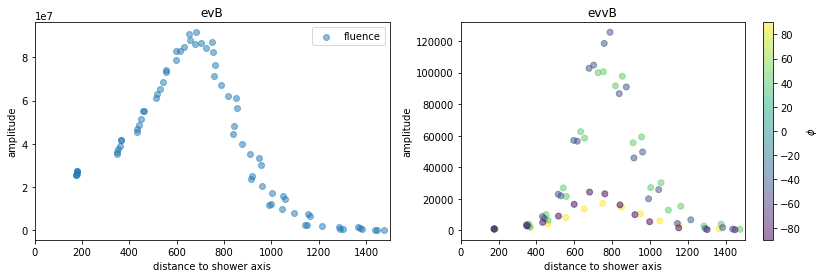

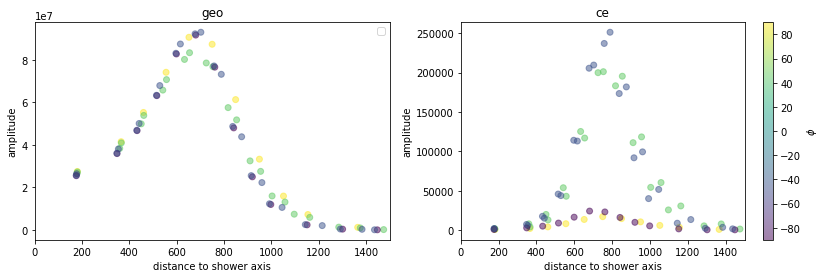

In [20]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.scatter(d2r[farr_geo != 0],farr_evB[farr_geo != 0],alpha=0.5,label='fluence')
plt.xlim([0,1500])
plt.title('evB')
plt.legend()
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.subplot(1,2,2)
plt.scatter(d2r[farr_geo != 0],farr_evvB[farr_geo != 0],alpha=0.5,c=np.arcsin(Sinphi[farr_geo != 0])*180/np.pi)
cbar=plt.colorbar()
cbar.set_label(r'$\phi$')
plt.xlim([0,1500])
plt.title('evvB')
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.scatter(d2r[farr_geo != 0],farr_geo[farr_geo != 0],alpha=0.5,c=np.arcsin(Sinphi[farr_geo != 0])*180/np.pi)
plt.xlim([0,1500])
plt.legend()
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
#plt.ylim([0,1e8])
plt.title('geo')
plt.subplot(1,2,2)
plt.scatter(d2r[farr_geo != 0],farr_ce[farr_geo != 0],alpha=0.5,c=np.arcsin(Sinphi[farr_geo != 0])*180/np.pi)
cbar=plt.colorbar()
cbar.set_label(r'$\phi$')
plt.xlabel('distance to shower axis')
plt.ylabel('amplitude')
plt.xlim([0,1500])
#plt.ylim([0,1e4])
plt.title('ce')